In [ ]:
!pip install scikit_optimize

     |████████████████████████████████| 102kB 3.9MB/s 


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, uniform, randint
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
#from sklearn.model_selection import 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, Lars, ElasticNetCV, BayesianRidge, LarsCV, LinearRegression, Ridge, RidgeCV, Lasso, LassoLars, LassoCV, LassoLarsCV, LassoLarsIC
#from sklearn.linear_model import 
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lightgbm
from lightgbm import LGBMRegressor
import xgboost as xgboost
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import matplotlib.pylab as pylab
import pickle


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [ ]:
pylab.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [ ]:
# set pandas/matplotlib options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

params = {'figure.figsize':(18,12),
          'figure.titleweight': 'extra bold', 
          'axes.labelsize': 'x-large',
          'axes.labelpad': 30,
          'axes.labelweight': 'bold',
          'axes.titlesize': 'xx-large',
          'axes.titlepad': 30,
          'axes.titleweight': 'extra bold',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
sns.set(rc=params)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

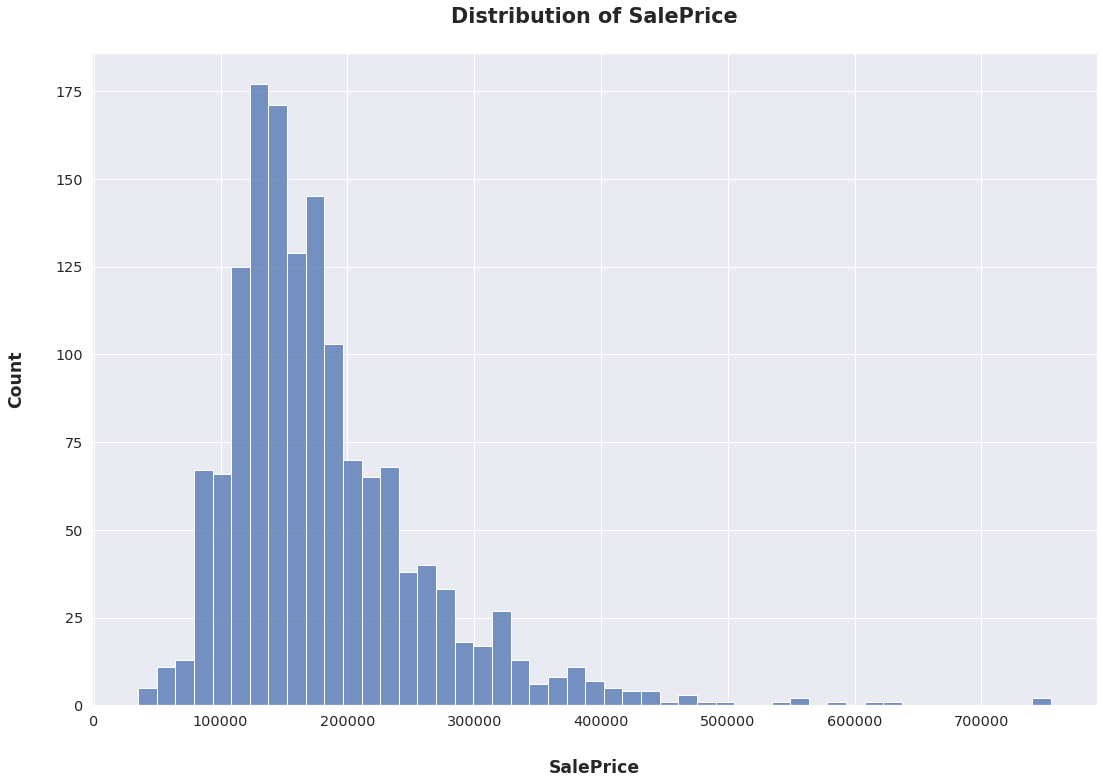

In [ ]:
# target variable is right skewed
sns.histplot(data=train, x='SalePrice')
plt.title('Distribution of SalePrice')
plt.show()

In [ ]:
# computes bounds for outliers
# outliers: x < Q1 - ( 1.5 * IQR) or x > Q3 + ( 1.5 * IQR) 
# extreme outliers: x < Q1 - ( 3.0 * IQR) or x > Q3 + ( 3.0 * IQR)
def quartile(data, lower_num, upper_num):
  q1, q3 = np.percentile(data, [25,75])
  print('First Quartile: ', q1)
  print('Third Quartile:', q3)
  IQR = q3 - q1
  lower = q1 - (lower_num * IQR)
  upper = q3 + (upper_num * IQR)
  print('Lower Bound(Q1 - (', lower_num, ' * IQR) = ', lower)
  print('Upper Bound(Q3 + (', upper_num, ' * IQR) = ', upper)
  return lower, upper

lower, upper = quartile(train['SalePrice'], 1.5, 1.5)

First Quartile:  129975.0
Third Quartile: 214000.0
Lower Bound(Q1 - ( 1.5  * IQR) =  3937.5
Upper Bound(Q3 + ( 1.5  * IQR) =  340037.5


In [ ]:
# check target feature 'SalePrice' for outliers
# 61 houses is too many to remove
len(train[(train['SalePrice']<lower) | (train['SalePrice']>upper)])

61

In [ ]:
# check for extreme outliers
# keep lower bound multiplied by 1.5 as multiplying by 3.0 would result in a negative value
lower, upper = quartile(train['SalePrice'], 1.5, 3)

First Quartile:  129975.0
Third Quartile: 214000.0
Lower Bound(Q1 - ( 1.5  * IQR) =  3937.5
Upper Bound(Q3 + ( 3  * IQR) =  466075.0


In [ ]:
# this is a more manageable number
print(len(train[(train['SalePrice']<lower) | (train['SalePrice']>upper)]))

12


In [ ]:
train[(train['SalePrice']<lower) | (train['SalePrice']>upper)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,748.0,Ex,TA,PConc,Ex,TA,No,GLQ,1904,Unf,0,312,2216,GasA,Ex,Y,SBrkr,2234,0,0,2234,1,0,2,0,1,1,Ex,9,Typ,1,Gd,Attchd,2009.0,Fin,3,1166,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
798,799,60,RL,104.0,13518,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,860.0,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1926,1926,GasA,Ex,Y,SBrkr,1966,1174,0,3140,0,0,3,1,4,1,Ex,11,Typ,2,Gd,BuiltIn,2009.0,Fin,3,820,TA,TA,Y,144,78,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,485000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,Ex,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,Ex,TA,Av,GLQ,240,Unf,0,1752,1992,GasA,Ex,Y,SBrkr,1992,876,0,2868,0,0,3,1,4,1,Ex,11,Typ,1,Gd,BuiltIn,2005.0,Fin,3,716,TA,TA,Y,214,108,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,H

In [ ]:
# remove these outliers from dataset
idx = train[(train['SalePrice']<lower) | (train['SalePrice']>upper)].index
train.drop(idx, inplace=True)

In [ ]:
# correlation of features in relation to target variable
corr = train.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.800000
GrLivArea        0.679068
GarageCars       0.653663
GarageArea       0.632507
TotalBsmtSF      0.594397
1stFlrSF         0.584448
YearBuilt        0.556740
FullBath         0.552082
YearRemodAdd     0.534765
GarageYrBlt      0.508040
TotRmsAbvGrd     0.502738
Fireplaces       0.461581
MasVnrArea       0.433622
BsmtFinSF1       0.364725
LotFrontage      0.336667
WoodDeckSF       0.334476
OpenPorchSF      0.325409
2ndFlrSF         0.287455
HalfBath         0.278858
LotArea          0.252031
BsmtFullBath     0.242846
BsmtUnfSF        0.211252
BedroomAbvGr     0.164610
ScreenPorch      0.081308
MoSold           0.079185
3SsnPorch        0.055720
PoolArea         0.033403
BsmtFinSF2      -0.011770
MiscVal         -0.019849
BsmtHalfBath    -0.031552
YrSold          -0.034292
Id              -0.034666
LowQualFinSF    -0.060257
OverallCond     -0.079676
MSSubClass      -0.086540
EnclosedPorch   -0.128520
KitchenAbvGr    -0.143610
Name: SalePr

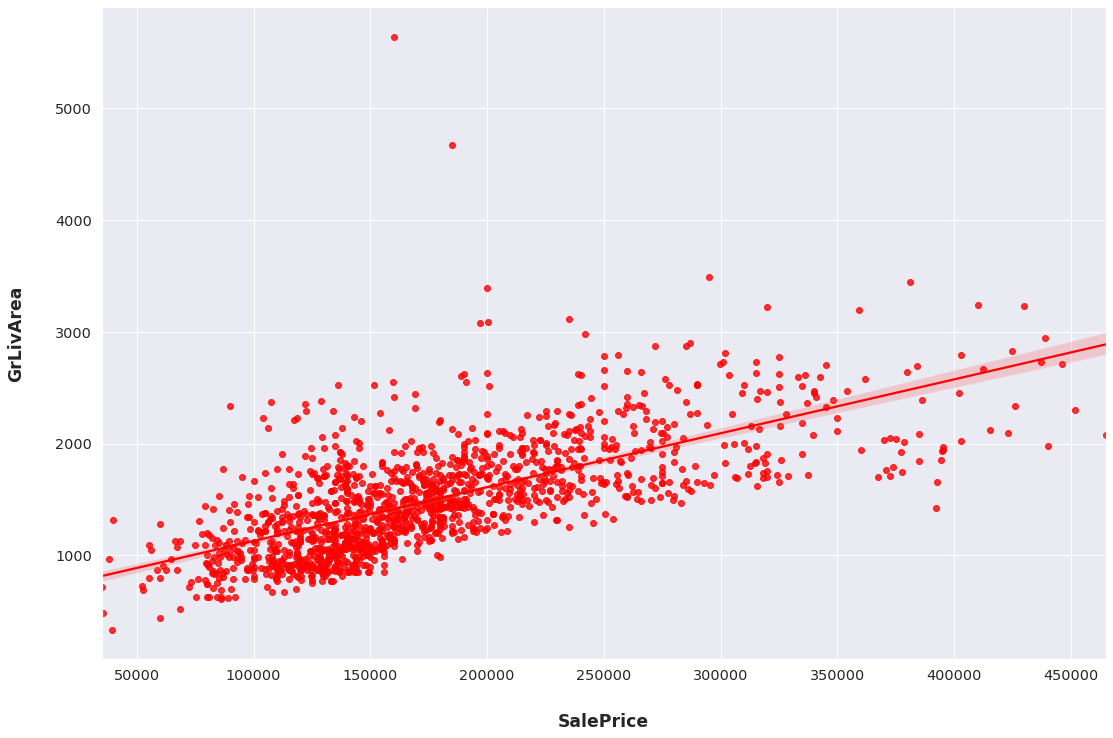

In [ ]:
# 'GrLivArea' seems important
sns.regplot(data=train, x='SalePrice', y='GrLivArea', color='red')
plt.show()

In [ ]:
lower, upper = quartile(train['GrLivArea'], 1.5, 1.5)

First Quartile:  1127.5
Third Quartile: 1768.0
Lower Bound(Q1 - ( 1.5  * IQR) =  166.75
Upper Bound(Q3 + ( 1.5  * IQR) =  2728.75


In [ ]:
# 24 is alot of outliers
len(train[(train['GrLivArea']<lower) | (train['GrLivArea']>upper)])

24

In [ ]:
# check for extreme outliers
lower, upper = quartile(train['GrLivArea'], 1.5, 3.0)

First Quartile:  1127.5
Third Quartile: 1768.0
Lower Bound(Q1 - ( 1.5  * IQR) =  166.75
Upper Bound(Q3 + ( 3.0  * IQR) =  3689.5


In [ ]:
len(train[(train['GrLivArea']<lower) | (train['GrLivArea']>upper)])

2

In [ ]:
# remove these outliers
idx = train[(train['GrLivArea']<lower) | (train['GrLivArea']>upper)].index
train.drop(idx, inplace=True)

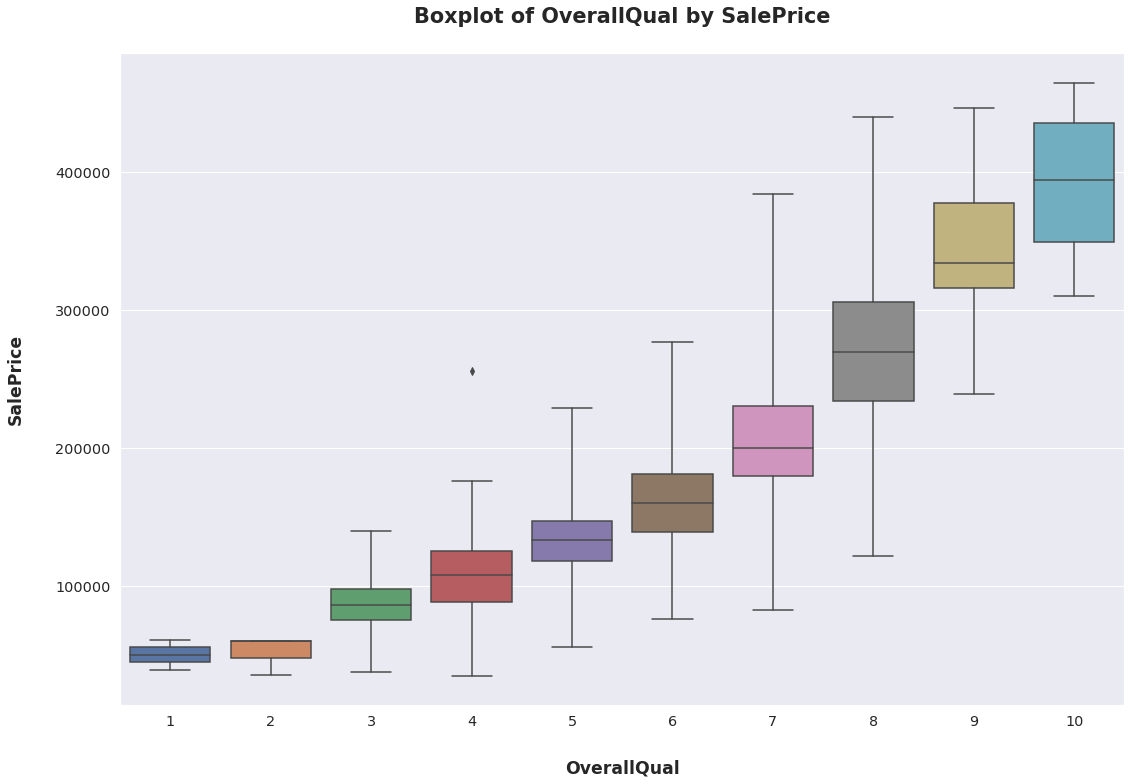

In [ ]:
# 'OverallQual' is another important feature
sns.boxplot(data=train, x='OverallQual', y='SalePrice', whis=3)
plt.title('Boxplot of OverallQual by SalePrice')
plt.show()

In [ ]:
# remove the single outlier with 'OverallQual' value of 4
idx = train[(train['OverallQual']==4) & (train['SalePrice']>200000)].index
train.drop(idx, inplace=True)

# record new length of train
train_length = len(train)

In [ ]:
# function to plot missing values
def plot_null(df):
    df_null = df.isnull().sum()
    null = df_null[df_null>0]
    null.sort_values(inplace=True)
    null.plot.bar()

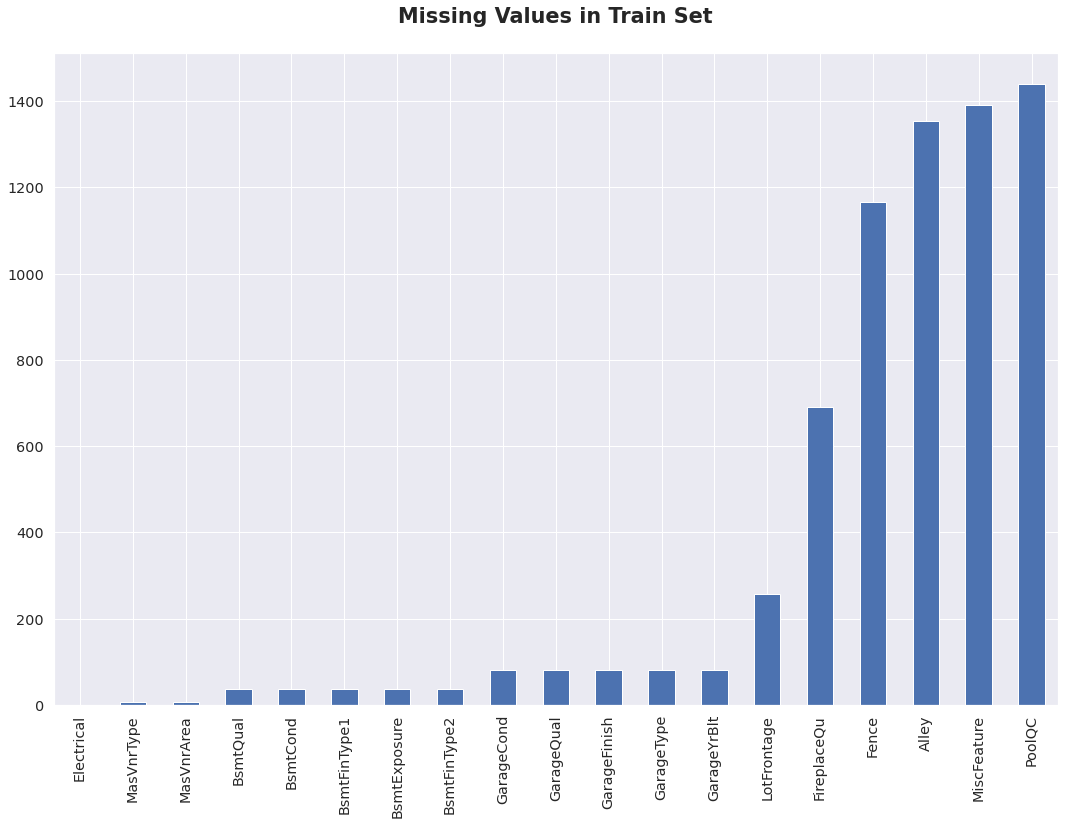

In [ ]:
plot_null(train)
plt.title('Missing Values in Train Set')
plt.show()

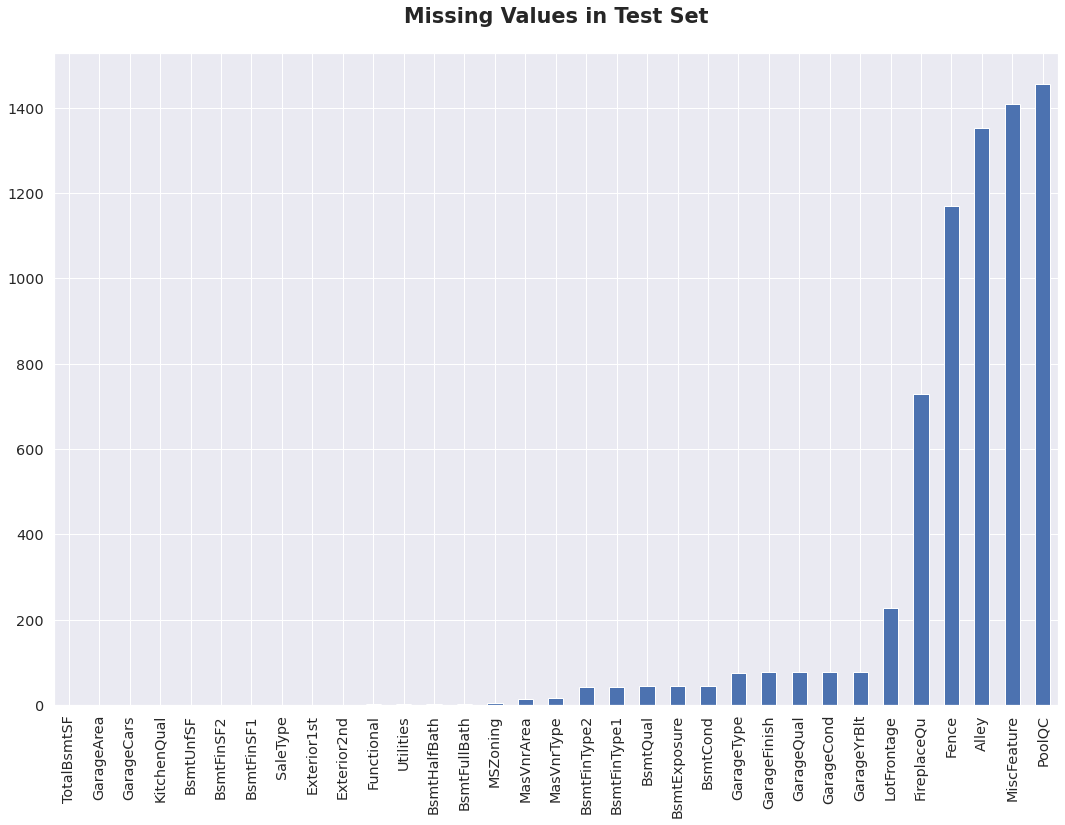

In [ ]:
plot_null(test)
plt.title('Missing Values in Test Set')
plt.show()

In [ ]:
df_all = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
# columns which provide little to no value
df_all.drop(columns=['Id', 'Alley', 'Utilities', 'PoolQC'], inplace=True)

In [ ]:
# change categorical data type to string
df_all['YrSold'] = df_all['YrSold'].apply(lambda x: str(x))
df_all['MSSubClass'] = df_all['MSSubClass'].apply(lambda x: str(x))

In [ ]:
from sklearn.impute import SimpleImputer

train = df_all.iloc[:train_length, :]
test = df_all.iloc[train_length:, :]

# fit imputers to train set which will be used during model deployment
num_cols = train.select_dtypes(exclude='object').columns
cat_cols = train.select_dtypes(include='object').columns
num_train = train[num_cols].drop(columns=['SalePrice'])
cat_train = train[cat_cols]
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer.fit(num_train)
mode_imputer.fit(cat_train)
with open('mode_imputer_housing', 'wb') as file:
    pickle.dump((mode_imputer), file)
with open('median_imputer_housing', 'wb') as file:
  pickle.dump((median_imputer), file)

In [ ]:
num_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'SalePrice'],
      dtype='object')

In [ ]:
cat_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'YrSold',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
# documentation indicated that a null value for these features was indicative of that feature being absent entirely

# impute missing values with 0
for col in ['TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 
            'BsmtFullBath', 'MasVnrArea', 'GarageYrBlt', 'BsmtUnfSF']:
    df_all[col] = df_all[col].fillna(0)
    
# impute missing values with 'None'
for col in ['Fence', 'SaleType', 'Functional', 
           'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageType', 'GarageFinish',
           'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'MiscFeature', 'Heating']:
           df_all[col] = df_all[col].fillna('None')

In [ ]:
# create ordinal features
for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
           'GarageQual', 'GarageCond', 'PoolQC']:
           df_all = df_all.replace({col: {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}})

for col in['BsmtFinType1', 'BsmtFinType2']:
  df_all = df_all.replace({col: {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}})

df_all = df_all.replace({'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                        'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
                        'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
                         'Electrical': {'None': 0, 'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                         'Functional': {'None': 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5,
                                      'Min2': 6, 'Min1': 7, 'Typ': 8}})

In [ ]:
train = df_all.iloc[:train_length, :]
test = df_all.iloc[train_length:, :]

## **YearBuilt**

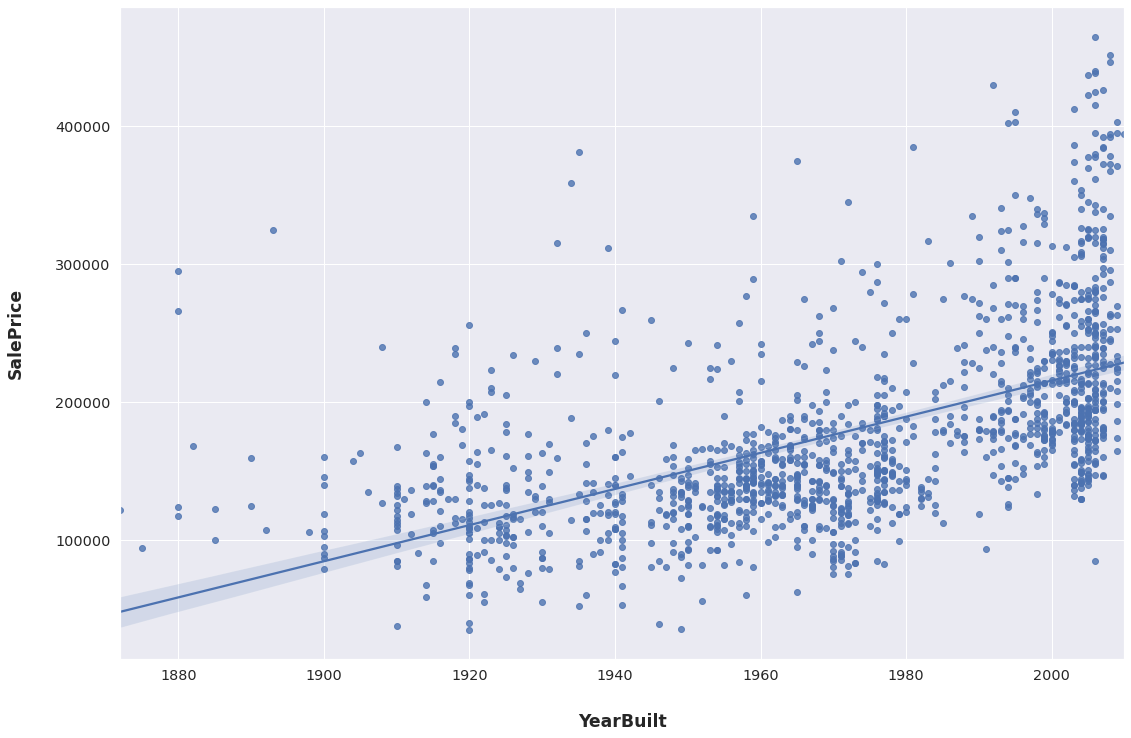

In [ ]:
sns.regplot(data=train, x='YearBuilt', y='SalePrice')
plt.show()

In [ ]:
# function to assign bins
def age_bins(year):
  if year == 0:
    return 0
  elif year >= 2000:
    return 4
  elif year >= 1980:
    return 3
  elif year >= 1960:
    return 2
  else:
    return 1

In [ ]:
for data in [train, test]:
  data['YearBuilt'] = data['YearBuilt'].apply(lambda x: age_bins(x))

train['YearBuilt'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1    483
4    378
2    363
3    221
Name: YearBuilt, dtype: int64

In [ ]:
df_all[['YearBuilt', 'SalePrice']].groupby(['YearBuilt'], as_index=False).median().sort_values(by='SalePrice', ascending=False)

,YearBuilt,SalePrice
3,4,221750.0
2,3,193000.0
1,2,147000.0
0,1,128950.0


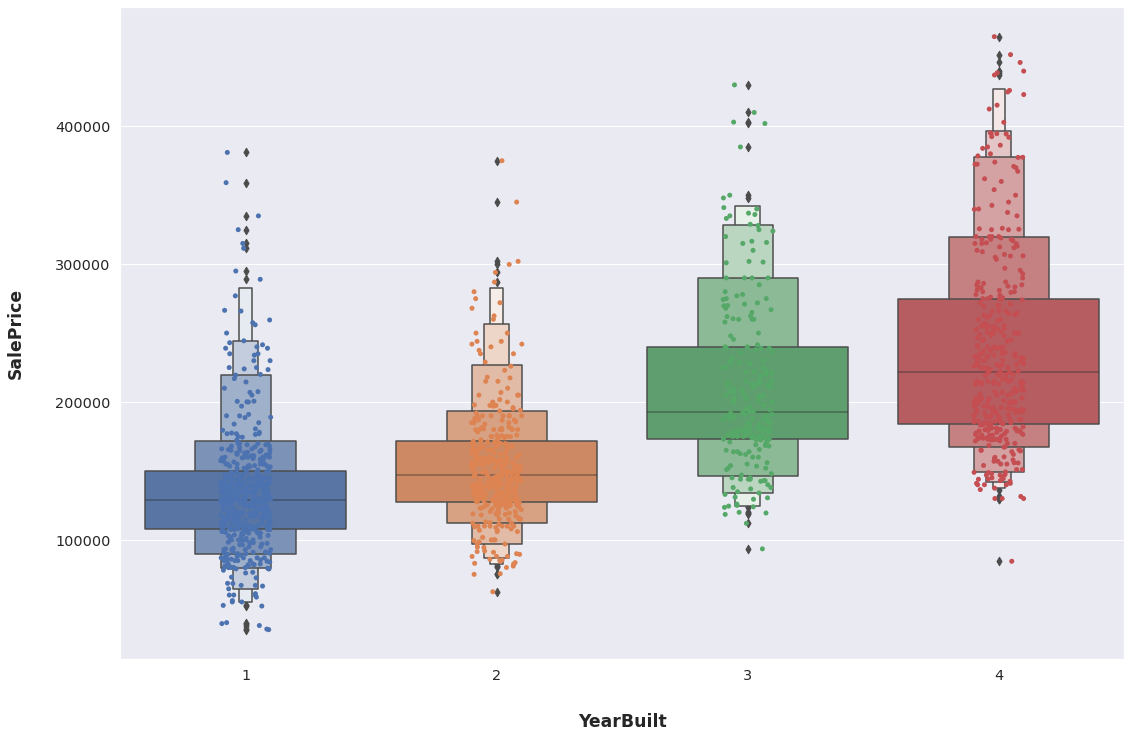

In [ ]:
sns.boxenplot(data=train, x='YearBuilt', y='SalePrice')
sns.stripplot(data=train, x='YearBuilt', y='SalePrice')
plt.show()

## **GarageYrBlt**

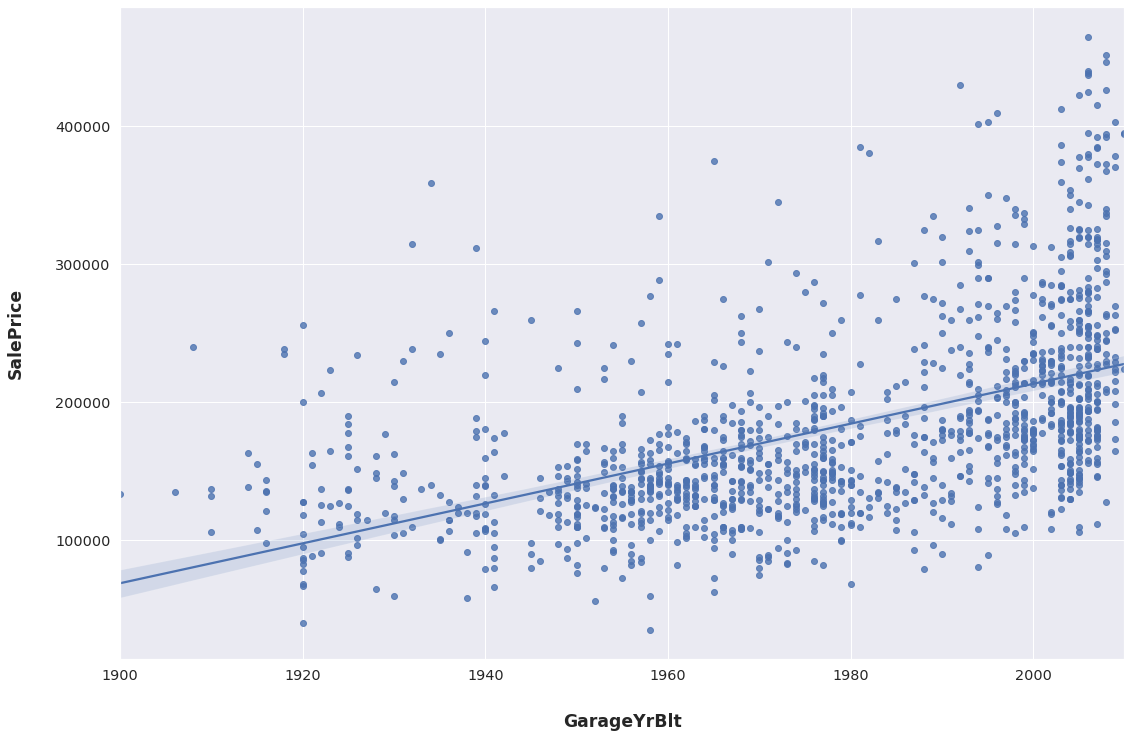

In [ ]:
sns.regplot(data=train[train['GarageYrBlt'] >= 1900], x='GarageYrBlt', y='SalePrice')
plt.show()

In [ ]:
for data in [train, test]:
  data['GarageYrBlt'] = data['GarageYrBlt'].apply(lambda x: age_bins(x))

train['GarageYrBlt'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4    392
2    371
1    314
3    287
0     81
Name: GarageYrBlt, dtype: int64

In [ ]:
train[['GarageYrBlt','SalePrice']].groupby(['GarageYrBlt'], as_index=False).median().sort_values(by='SalePrice', ascending=False)

,GarageYrBlt,SalePrice
4,4,219355.0
3,3,180500.0
2,2,147000.0
1,1,133800.0
0,0,100000.0


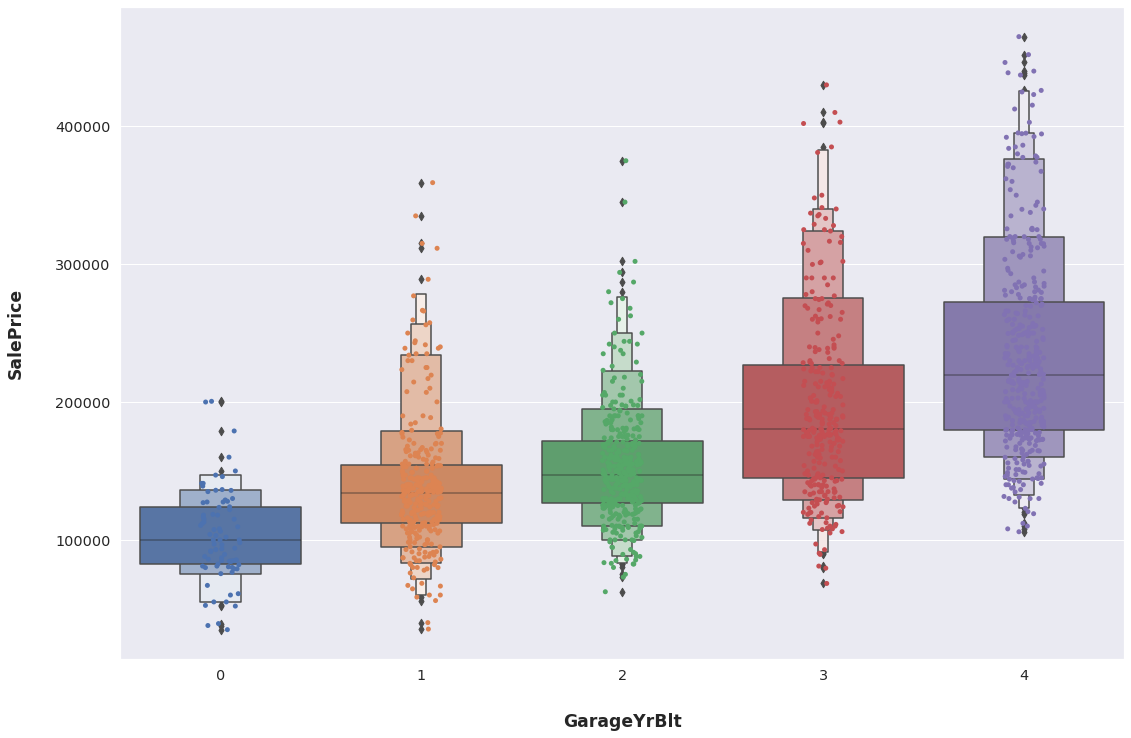

In [ ]:
sns.boxenplot(data=train, x='GarageYrBlt', y='SalePrice')
sns.stripplot(data=train, x='GarageYrBlt', y='SalePrice')
plt.show()

## **MoSold**

In [ ]:
# explore MoSold feature
train[['MoSold','SalePrice']].groupby('MoSold', as_index=False).median()

,MoSold,SalePrice
0,1,145000.0
1,2,173250.0
2,3,162900.0
3,4,146125.0
4,5,154000.0
5,6,162900.0
6,7,163900.0
7,8,174450.0
8,9,185900.0
9,10,158500.0


In [ ]:
# binning 'MoSold' into seasons may yield better results

# function that returns season during which the house was sold
def seasons(x):
  if 3 <= x <= 5:
    return 'spring'
  elif 6 <= x <= 8:
    return 'summer'
  elif 9 <= x <= 11:
    return 'fall'
  else:
    return 'winter'

for data in [train, test]:
  data['SeasonSold'] = data['MoSold'].apply(lambda x: seasons(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
train[['SeasonSold','SalePrice']].groupby(['SeasonSold'], as_index=False).median()

,SeasonSold,SalePrice
0,fall,168995.0
1,spring,154000.0
2,summer,164600.0
3,winter,170000.0


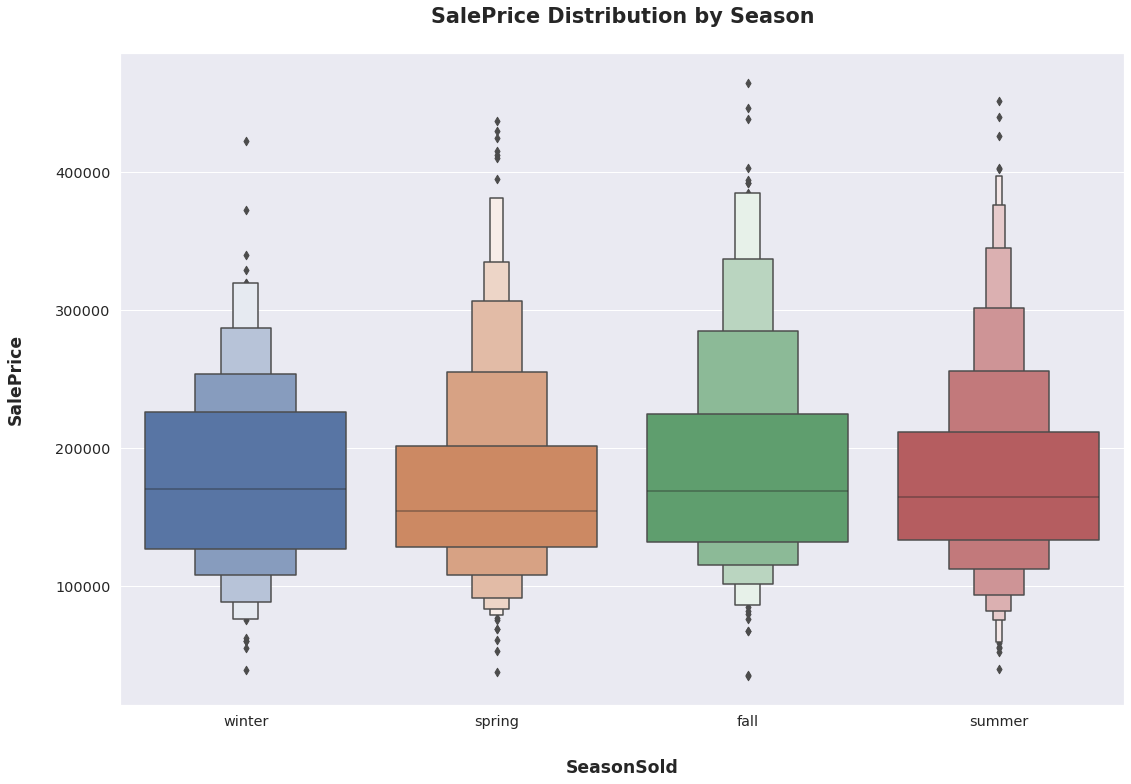

In [ ]:
sns.boxenplot(x='SeasonSold', y='SalePrice', data=train)
plt.title('SalePrice Distribution by Season')
plt.show()

## **YearRemodAdd**

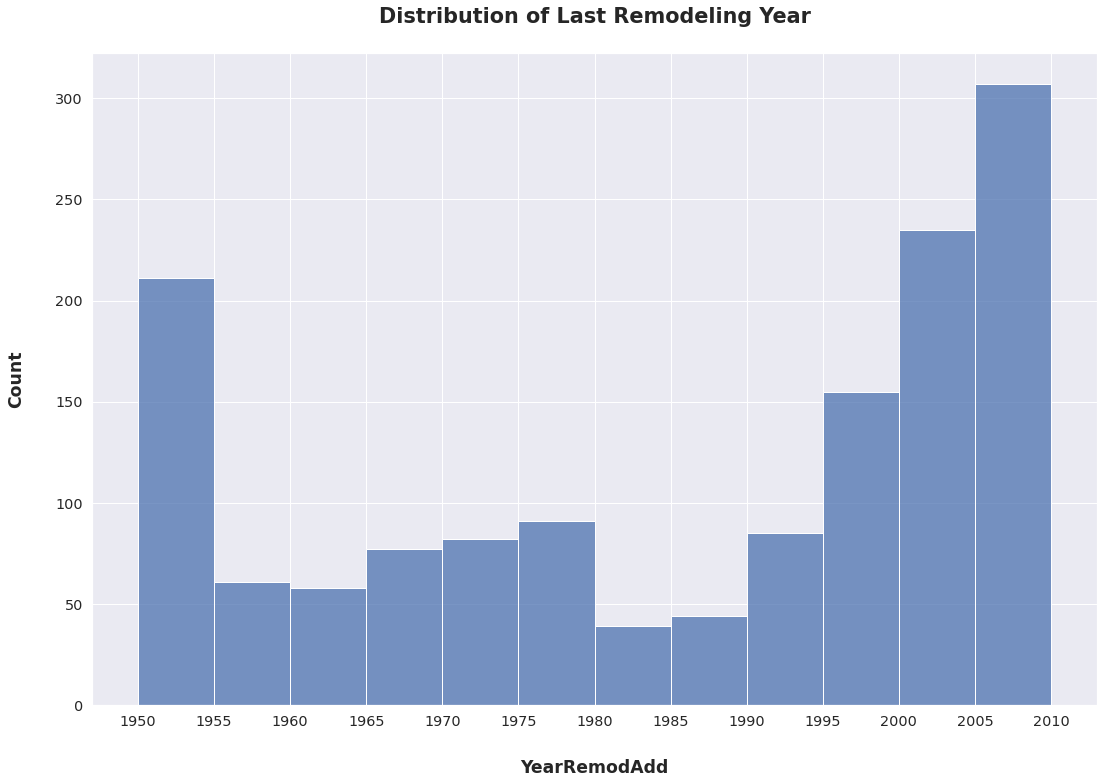

In [ ]:
sns.histplot(data=train, x='YearRemodAdd', bins=12)
plt.title('Distribution of Last Remodeling Year')
plt.xticks(ticks=np.linspace(1950,2010,13))
plt.show()

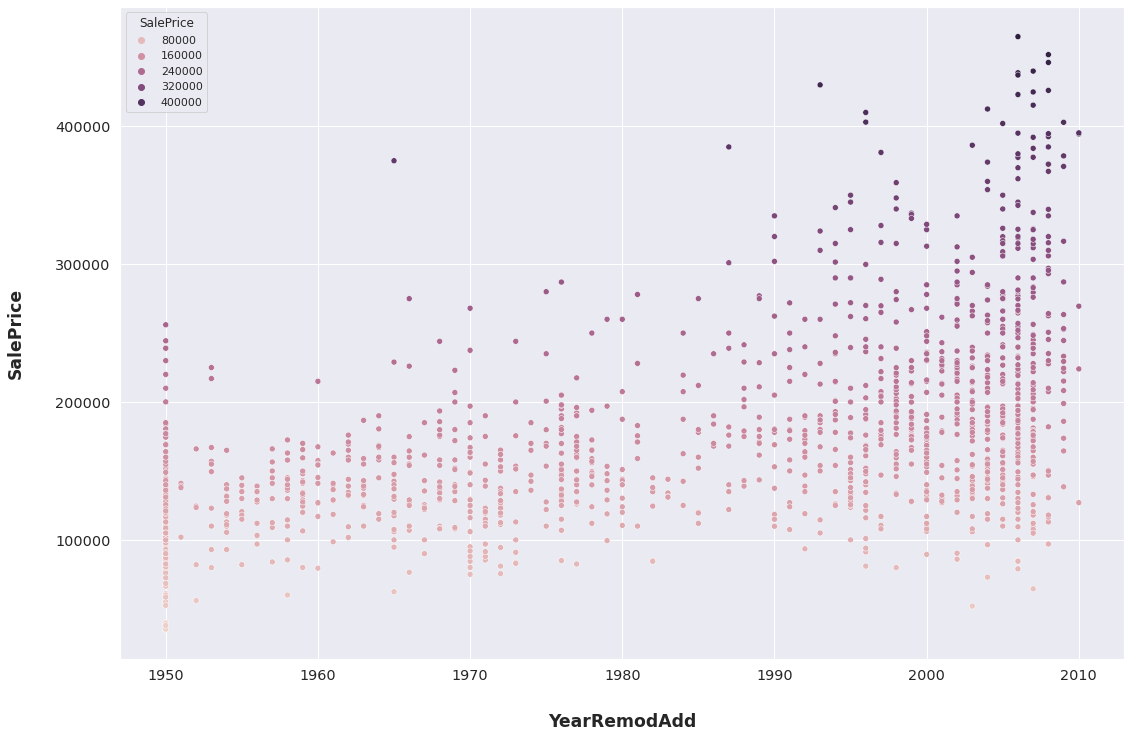

In [ ]:
sns.scatterplot(data=train, x='YearRemodAdd', hue='SalePrice', y='SalePrice')

In [ ]:
def remodel_bins(x):
  if x >= 2000:
    return 4
  elif x >= 1990:
    return 3
  elif x >= 1970:
    return 2
  else:
    return 1

for data in [train, test]:
  data['YearRemodAdd'] = data['YearRemodAdd'].apply(lambda x: remodel_bins(x))
train['YearRemodAdd'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


4    542
1    407
2    256
3    240
Name: YearRemodAdd, dtype: int64

In [ ]:
train[['YearRemodAdd','SalePrice']].groupby(['YearRemodAdd'], as_index=False).median().sort_values(by='SalePrice', ascending=False)

,YearRemodAdd,SalePrice
3,4,200000.0
2,3,185000.0
1,2,149250.0
0,1,129000.0


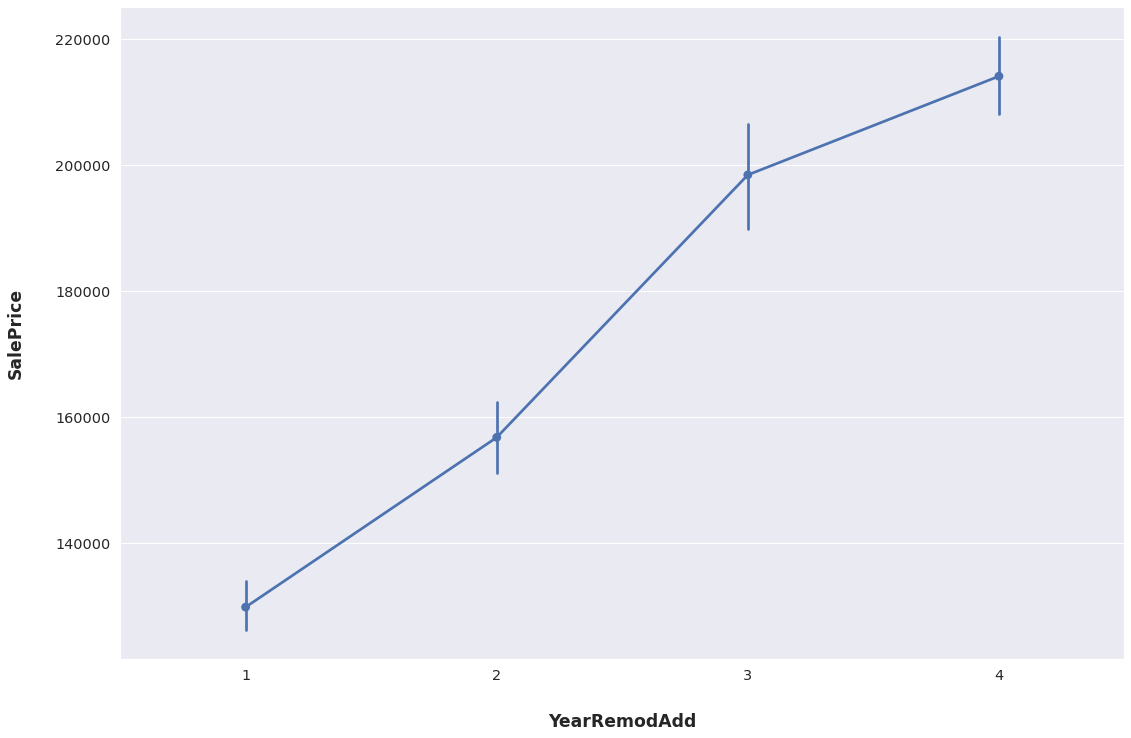

In [ ]:
sns.pointplot(data=train, x='YearRemodAdd', y='SalePrice')
plt.show()

In [ ]:
# create new features

df_all = pd.concat([train, test]).reset_index(drop=True)

df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['GrLivArea']
df_all['BsmtBath'] = df_all['BsmtFullBath'] + (0.5*df_all['BsmtHalfBath'])
df_all['AboveGroundBath'] = df_all['FullBath'] + (0.5*df_all['HalfBath'])
df_all['TotalBath'] = df_all['BsmtBath'] + df_all['AboveGroundBath']
df_all['TotalPorchSF'] = df_all['EnclosedPorch'] + df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['ScreenPorch']
df_all['TotalPorchAndDeckSF'] = df_all['TotalPorchSF'] + df_all['WoodDeckSF']

df_all['HasPorch'] = df_all['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasDeck'] = df_all['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

# categorical features which require non-numerical values
#df_all['MoSold'] = df_all['MoSold'].apply(lambda x: str(x))

df_all['BsmtUnfSF'] = df_all['BsmtUnfSF'].apply(lambda x: float(x))

In [ ]:
df_all.drop(columns=['PoolArea', 'MoSold'], inplace=True)

Text(0.5, 1.0, 'Missing Values')

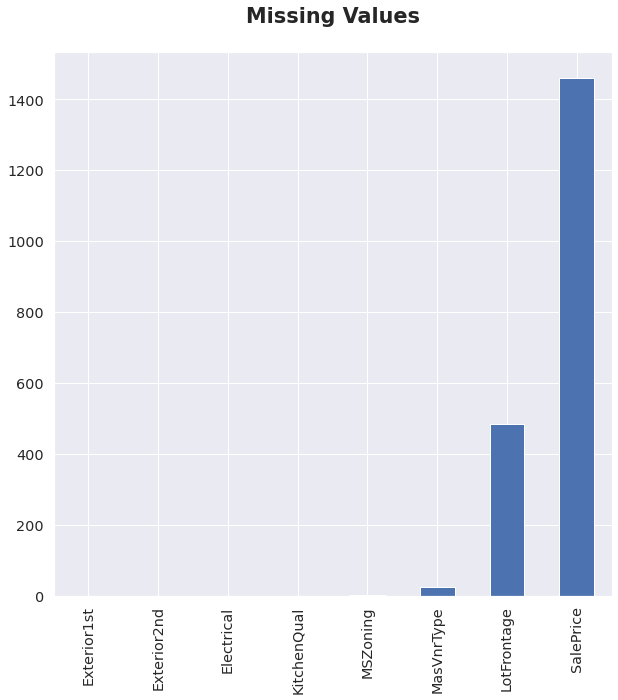

In [ ]:
plt.figure(figsize=(10,10))
missing = plot_null(df_all)
plt.title('Missing Values')

In [ ]:
# impute these null values with the mode
missing = ('Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'MSZoning', 'MasVnrType')
for col in missing:
  df_all[col] = df_all[col].fillna(train[col].mode()[0])

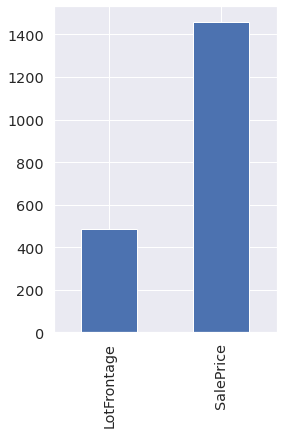

In [ ]:
# null values remaining
plt.figure(figsize=(4,6))
plot_null(df_all)

In [ ]:
# create new features that are combinations of important features
important_features = ['TotalSF', 'OverallQual', 'ExterQual', 'KitchenQual', 'GarageCars', 'TotalBath', 'YearBuilt', 'BsmtQual', 'TotRmsAbvGrd']

feature_combinations = []
for col_one in important_features:
  for col_two in important_features:
    if col_one != col_two:
      new_col = col_one + col_two
      feature_combinations.append(new_col)
      df_all[new_col] = df_all[col_one] * df_all[col_two]

In [ ]:
corr = df_all.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice                  1.000000
TotalSFOverallQual         0.907848
OverallQualTotalSF         0.907848
ExterQualTotalSF           0.883943
TotalSFExterQual           0.883943
KitchenQualTotalSF         0.883310
TotalSFKitchenQual         0.883310
TotalSFBsmtQual            0.870103
BsmtQualTotalSF            0.870103
GarageCarsTotalSF          0.837038
TotalSFGarageCars          0.837038
OverallQualKitchenQual     0.825339
KitchenQualOverallQual     0.825339
ExterQualOverallQual       0.823268
OverallQualExterQual       0.823268
TotalBathOverallQual       0.821013
OverallQualTotalBath       0.821013
OverallQualGarageCars      0.819841
GarageCarsOverallQual      0.819841
YearBuiltTotalSF           0.811628
TotalSFYearBuilt           0.811628
TotalSF                    0.810727
TotalSFTotalBath           0.810695
TotalBathTotalSF           0.810695
OverallQualBsmtQual        0.808374
BsmtQualOverallQual        0.808374
OverallQual                0.807201
TotRmsAbvGrdOverallQual    0

In [ ]:
# continuous variables
continuous = ['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageArea',
 'TotalSF',
 'LotArea',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'TotalPorchSF',
 'TotalPorchAndDeckSF',
 'SalePrice']

# prepare list of numerical columns
# check these columns for skewness
numerical = continuous + feature_combinations
skewed = df_all[numerical].apply(lambda x: skew(x, nan_policy='omit'))
skewed = skewed[abs(skewed)>0.5]
skewed.sort_values(ascending=False)

LotArea                               13.5236
LowQualFinSF                          12.3839
BsmtFinSF2                            4.14646
MasVnrArea                            2.56866
OpenPorchSF                           2.54419
TotalSFTotRmsAbvGrd                    2.3629
TotRmsAbvGrdTotalSF                    2.3629
TotalPorchSF                          2.23539
WoodDeckSF                            1.85571
ExterQualTotalSF                      1.52502
TotalSFExterQual                      1.52502
TotalSFTotalBath                      1.50538
TotalBathTotalSF                      1.50538
OverallQualTotalSF                    1.45599
TotalSFOverallQual                    1.45599
KitchenQualTotalSF                    1.42987
TotalSFKitchenQual                    1.42987
TotalPorchAndDeckSF                   1.38546
1stFlrSF                              1.25401
GarageCarsTotalBath                   1.24061
TotalBathGarageCars                   1.24061
TotalBathTotRmsAbvGrd             

In [ ]:
# transform skewed variables
df_all[skewed.index] = np.log1p(df_all[skewed.index])

In [ ]:
# check for skewness again
skewed = df_all[numerical].apply(lambda x: skew(x, nan_policy='omit'))
skewed = skewed[abs(skewed)>0.5]
skewed.sort_values(ascending=False)

LowQualFinSF                          8.64939
BsmtFinSF2                            2.45871
MasVnrArea                           0.544192
TotalPorchSF                        -0.565549
LotArea                             -0.567637
BsmtFinSF1                          -0.615229
TotalBathGarageCars                 -0.629081
GarageCarsTotalBath                 -0.629081
OverallQualTotalSF                  -0.657886
TotalSFOverallQual                  -0.657886
LotFrontage               -0.9087371824461908
TotalBathBsmtQual                     -1.2876
BsmtQualTotalBath                     -1.2876
TotalPorchAndDeckSF                  -1.35291
GarageCarsOverallQual                -1.56797
OverallQualGarageCars                -1.56797
TotRmsAbvGrdGarageCars               -1.67273
GarageCarsTotRmsAbvGrd               -1.67273
BsmtUnfSF                            -2.15082
GarageCarsTotalSF                    -3.38856
TotalSFGarageCars                    -3.38856
TotalBsmtSF                       

In [ ]:
y = df_all['SalePrice']
df_all.drop(columns=['SalePrice'], inplace=True)
numerical.remove('SalePrice')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# onehotencode categorical features
cat_cols = df_all.select_dtypes(include='object').columns
df_cat = df_all[cat_cols]
df_all.drop(columns=cat_cols, inplace=True)

encoder = OneHotEncoder(sparse=False)
encoder.fit(df_cat)
df_cat_transformed = pd.DataFrame(encoder.transform(df_cat), columns=encoder.get_feature_names(list(cat_cols)))

# save encoder object for use during deployment
with open('encoder_housing', 'wb') as file:
    pickle.dump((encoder), file)

df_all = pd.concat([df_all, df_cat_transformed], axis=1)

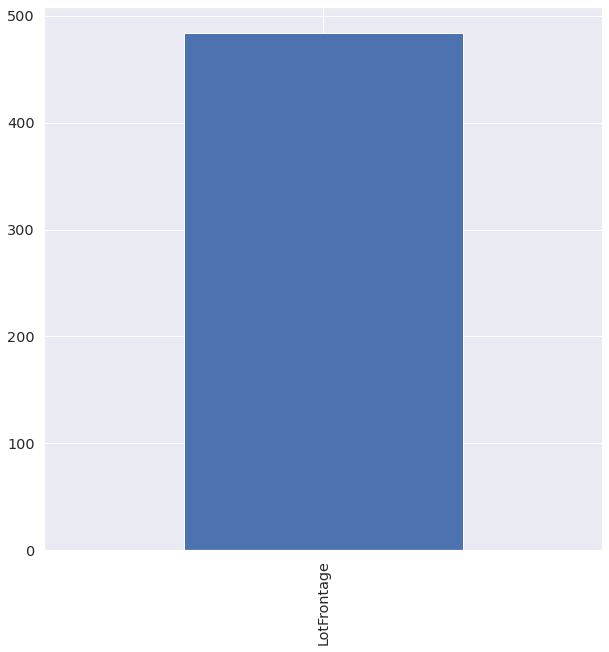

In [ ]:
# only 'LotArea' contains null values
plt.figure(figsize=(10,10))
plot_null(df_all)
plt.show()

In [ ]:
# impute missing 'LotArea' values with BayesianRidge imputer
train = df_all.iloc[:train_length,:]
test = df_all.iloc[train_length:,:]

imputer = IterativeImputer(BayesianRidge())
imputer.fit(train)
imputed_train = imputer.transform(train)
imputed_test = imputer.transform(test)

X_train = pd.DataFrame(imputed_train, columns = df_all.columns)
X_test = pd.DataFrame(imputed_test, columns = df_all.columns)
y_train = y.iloc[:train_length]
y_test = y.iloc[train_length:]

In [ ]:
# applies polynomial transformations
def polynomials(df, col):
  col_sqrt = col + '_sqrt'
  df[col_sqrt] = df[col].apply(lambda x: x**(1/2))

  col_squared = col + '_squared'
  df[col_squared] = df[col].apply(lambda x: x**2)

  col_cubed = col + '_cubed'
  df[col_cubed] = df[col].apply(lambda x: x**3)
  
  col_poly_four = col + '_four'
  df[col_poly_four] = df[col].apply(lambda x: x**4)

for col in numerical:
  polynomials(X_train, col)
  polynomials(X_test, col)

In [ ]:
# prepare KFold object and scaler
folds = KFold(n_splits=10, random_state=28, shuffle=True)
scaler = RobustScaler()

In [ ]:
# hyperparameter tuning function utilizing BayesSearchCV technique
def bayes_search(estimator, search_space, folds, n_iter):
  cv = BayesSearchCV(estimator, search_space, n_iter=n_iter, n_jobs=-1, cv=folds, scoring='neg_mean_squared_error', verbose=0, random_state=28)
  cv.fit(X_train, y_train)

  print('best parameters:', '{')
  for key,value in cv.best_params_.items():
    print('\t', key, ':', value)
  print('\t', '}')
  print('\n')
  print('best score:', np.sqrt(-cv.best_score_))

  return cv

In [ ]:
# returns cross-validated root mean squared error
def cv(model, X, y, folds):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                                   cv=folds))
    return rmse

In [ ]:
def randomize_search(estimator, param_distributions, folds, n_iter=1000):
    #folds = KFold(n_splits=5, random_state=28, shuffle=True)
    
    grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_distributions, cv=folds,
                             n_jobs=-1, n_iter=n_iter, scoring='neg_mean_squared_error', random_state=28)
    grid_fit = grid.fit(X_train, y_train)
    
    score = np.sqrt(-grid_fit.best_score_)
    params = grid_fit.best_params_
    return score, params, grid_fit

# Ridge

In [ ]:
# find optimal alpha parameter
space = {'ridge__alpha': [0.0, 50.0]}
ridge = bayes_search(make_pipeline(scaler, Ridge(random_state=28, max_iter=-1)), space, folds, 25)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best parameters: {
	 ridge__alpha : 14.234588414980824
	 }


best score: 0.10863943689165471


In [ ]:
ridge_alpha = ridge.best_params_['ridge__alpha']
ridge = make_pipeline(scaler, Ridge(random_state=28, max_iter=-1, alpha=ridge_alpha))
score = cv(ridge, X_train, y_train, folds)
print(score.mean())

0.10790799447336888


In [ ]:
# fit and save model
ridge.fit(X_train, y_train)
with open('ridge', 'wb') as file:
    pickle.dump(ridge, file)

# Lasso

In [ ]:
# find optimal alpha parameter
space = {
    'lasso__alpha': [0.0, 0.01]
}
lasso = bayes_search(make_pipeline(scaler, Lasso(random_state=28, max_iter=100000)), space, folds, 25)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best parameters: {
	 lasso__alpha : 0.00036458588212236805
	 }


best score: 0.1066478370732673


In [ ]:
lasso_alpha = lasso.best_params_['lasso__alpha']
lasso = make_pipeline(scaler, Lasso(random_state=28, max_iter=100000, alpha=lasso_alpha))
score = cv(lasso, X_train, y_train, folds)
print(score.mean())

0.10588996050854445


In [ ]:
# fit and save model
lasso.fit(X_train, y_train)
with open('lasso', 'wb') as file:
    pickle.dump(lasso, file)

# XGB

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror',
                       nthread=-1,
                       seed=28,
                       random_state=28)

In [ ]:
# start with learning rate and number of estimators and build from there
params = {'learning_rate': [.0001, .0005, .001],
          'n_estimators': [14000,24000]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 15)

best parameters: {
	 learning_rate : 0.001
	 n_estimators : 22643
	 }


best score: 0.11445439382732354


In [ ]:
xgb.set_params(n_estimators=22643, learning_rate=.001)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=22643,
             n_jobs=1, nthread=-1, objective='reg:squarederror',
             random_state=28, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=28, silent=None, subsample=1, verbosity=1)

In [ ]:
params = {'max_depth': [2,10],
          'min_child_weight': [0,10]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 10)

best parameters: {
	 max_depth : 4
	 min_child_weight : 6
	 }


best score: 0.11340473366143913


In [ ]:
xgb.set_params(max_depth= 4, min_child_weight= 6)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=4, min_child_weight=6, missing=None, n_estimators=22643,
             n_jobs=1, nthread=-1, objective='reg:squarederror',
             random_state=28, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=28, silent=None, subsample=1, verbosity=1)

In [ ]:
params = {'subsample': [.7,.8,.9,1],
          'colsample_bytree': [.7,.8,.9,1]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 10)

best parameters: {
	 colsample_bytree : 0.9
	 subsample : 0.7
	 }


best score: 0.10998319617310164


In [ ]:
xgb.set_params(subsample=.7, colsample_bytree=.9)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=4, min_child_weight=6, missing=None, n_estimators=22643,
             n_jobs=1, nthread=-1, objective='reg:squarederror',
             random_state=28, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=28, silent=None, subsample=0.7, verbosity=1)

In [ ]:
score = cv(xgb, X_train, y_train, folds)
print(score.mean())

0.10927045105230711


In [ ]:
xgb.fit(X_train, y_train)
with open('xgb_housing', 'wb') as file:
  pickle.dump(xgb, file)

# LGBM

In [ ]:
lgbm = LGBMRegressor(objective='regression', random_state=28, seed=28, verbose=0, nthread=-1, n_jobs=-1)

In [ ]:
params = {'learning_rate': [.0001, .0005, .001],
          'n_estimators': [12000, 24000]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 15)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best parameters: {
	 learning_rate : 0.001
	 n_estimators : 12481
	 }


best score: 0.1217220552392927


In [ ]:
lgbm.set_params(learning_rate=.001, n_estimators=12481)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=12481, n_jobs=-1, nthread=-1, num_leaves=31,
              objective='regression', random_state=28, reg_alpha=0.0,
              reg_lambda=0.0, seed=28, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [ ]:
params = {'max_depth': [2,10],
          'min_child_weight': [0,10]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 10)

best parameters: {
	 max_depth : 3
	 min_child_weight : 5
	 }


best score: 0.11784420459901622


In [ ]:
lgbm.set_params(max_depth=3, min_child_weight=5)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=3,
              min_child_samples=20, min_child_weight=5, min_split_gain=0.0,
              n_estimators=12481, n_jobs=-1, nthread=-1, num_leaves=31,
              objective='regression', random_state=28, reg_alpha=0.0,
              reg_lambda=0.0, seed=28, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [ ]:
params = {'subsample': [.7,.8,.9,1],
          'colsample_bytree': [.7,.8,.9,1]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 10)

best parameters: {
	 colsample_bytree : 0.7
	 subsample : 0.9
	 }


best score: 0.1174448784706848


In [ ]:
score = rcv(lgbm, X_train, y_train, folds)
print(score.mean())

0.11721610280855592


In [ ]:
lgbm.fit(X_train, y_train)
with open('lgbm_housing', 'wb') as file:
    pickle.dump(lgbm, file)

# Stack

In [ ]:
with open('ridge_housing', 'rb') as handle:
  ridge = pickle.load(handle)
with open('lasso_housing', 'rb') as handle:
  lasso = pickle.load(handle)
with open('xgb_housing', 'rb') as handle:
  xgb = pickle.load(handle)

In [ ]:
stack = StackingRegressor(estimators=[('lasso', lasso),
              ('ridge', ridge)],
              cv=folds,
              n_jobs=-1,
              passthrough=True,
              final_estimator=xgb)

In [ ]:
score = cv(stack, X_train, y_train, folds)
print(score.mean())

0.10769442686113218


In [ ]:
stack.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=28, shuffle=True),
                  estimators=[('lasso',
                               Pipeline(memory=None,
                                        steps=[('robustscaler',
                                                RobustScaler(copy=True,
                                                             quantile_range=(25.0,
                                                                             75.0),
                                                             with_centering=True,
                                                             with_scaling=True)),
                                               ('lasso',
                                                Lasso(alpha=0.00036458588212236805,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=100000,
               

In [89]:
with open('stack_housing', 'wb') as file:
  pickle.dump(stack, file)

In [90]:
predictions = stack.predict(X_test)
results = pd.read_csv('sample_submission.csv')

In [92]:
results['SalePrice'] = np.exp(predictions)

In [94]:
results.to_csv('submission.csv')